# Ungraded Lab: Transfer Learning

In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called _transfer learning_ and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

1. just get the convolution layers of one model
2. attach some dense layers onto it
3. train just the dense network
4. evaluate the results

Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

## Setup the pretrained model

You will need to prepare the pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3` as you've been doing in the last few labs.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
# The weights have been pre-downloaded for you from the following URL:
import os

download_path = '/content/tf_models/'
file_path = os.path.join(download_path, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

if not os.path.exists(download_path):
    os.makedirs(download_path)

if not os.path.exists(file_path):
    !wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O {file_path}
    print('The file has been successfully downloaded to the path:', download_path)
else:
    print('The file already exists in the environment.')

--2025-02-06 18:39:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.207, 108.177.11.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/tf_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/tf_models/ 100%[===================>]  83.84M   141MB/s    in 0.6s    

2025-02-06 18:39:19 (141 MB/s) - ‘/content/tf_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

El archivo se ha descargado exitosamente en la ruta: /content/tf_models/


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = file_path

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to `mixed7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Add dense layers for your classifier

Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Dense
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Prepare the dataset

Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# View current directory
print(f"The current path is: {os.getcwd()}")

# Path with cat and dog pictures
path_cats_dogs_pic = '/content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W1/Ungraded/Lab1'
os.chdir(path_cats_dogs_pic)
print(f"The new current path is: {path_cats_dogs_pic}")

# Unzip the files only if the Files folder exists and is a directory in the file system
zip_files = 'Files.zip'  # Name of the zip folder
unzip_files = 'Files/'   # Name of the unzip folder

if os.path.exists(unzip_files) and os.path.isdir(unzip_files):
  print(f"La carpeta '{unzip_files}' ya existe y es un directorio.")
else:
  print(f"La carpeta '{unzip_files}' no existe o no es un directorio.")
  zip_ref = zipfile.ZipFile(zip_files, 'r')
  zip_ref.extractall(unzip_files)
  zip_ref.close()

# View files
!ls

The current path is: /content
The new current path is: /content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W1/Ungraded/Lab1
La carpeta 'Files/' ya existe y es un directorio.
C2_W1_Lab_1_cats_vs_dogs.ipynb	cat_2.jpeg  dog_1.jpeg	dog_3.jpeg  Files.zip
cat_1.jpeg			cat_3.jpeg  dog_2.jpeg	Files	    history_augmented.pkl


In [ ]:
import zipfile

def unzip_files(zip_file='', extract_dir=''):
    if os.path.exists(extract_dir) and os.path.isdir(extract_dir):
        print(f"The folder '{extract_dir}' already exists and is a directory.")
    else:
        print(f"The folder '{extract_dir}' does not exist or is not a directory.")
        print("Unzipping files...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Files unzipped successfully.")

# Especificar la ruta del archivo ZIP y la carpeta de extracción
zip_files = 'Files.zip'  # Nombre del archivo ZIP
extract_folder = 'Files/'   # Nombre de la carpeta de extracción

file_path = '/content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W3/Ungraded/Lab1'
os.chdir(file_path)
print(f"The current path is: {file_path}")

# Llamar a la función para descomprimir los archivos
unzip_files(zip_files, extract_folder)

The current path is: /content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W3/Ungraded/Lab1
The folder 'Files/' already exists and is a directory.


In [ ]:
BASE_DIR = os.path.join(os.getcwd(), 'Files/Files', 'cats_and_dogs_filtered')
print(f'Contents of base directory are: {os.listdir(BASE_DIR)}')

# Train and validation directory
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Contents of base directory are: ['train', 'validation']


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

def create_dataset(directory, image_size, batch_size=None, label_mode=None):
  return image_dataset_from_directory(directory=directory, image_size=image_size, batch_size=batch_size, label_mode=label_mode)

# Prepare the training set

train_dataset = create_dataset(train_dir, (150,150), 20, 'binary')

# Prepare the validation set
validation_dataset = create_dataset(validation_dir, (150,150), 20, 'binary')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


When using pretrained models, you should make it a habit to check the documentation for any preprocessing steps. In this case, the [InceptionV3 documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3) says that the inputs should be scaled to the range [-1,1]. It has a [`preprocess_input()`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input)  method that you can use to rescale the inputs. The cell below defines a `preprocess` function that uses this method, which you can then map to the datasets.

In [ ]:
import tensorflow as tf

# Define the preprocess function
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

# Apply the preprocessing to the datasets
train_dataset_scaled = train_dataset.map(preprocess)
validation_dataset_scaled = validation_dataset.map(preprocess)

In [ ]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

## Prepare the Model for Training

You will also add data augmentation layers to avoid your model from overfitting.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomContrast, RandomZoom

# Create a model with data augmentation layers
data_augmentation = Sequential([
      RandomFlip("horizontal"),
      RandomRotation(0.4),
      RandomTranslation(0.2,0.2),
      RandomContrast(0.4),
      RandomZoom(0.2),
    ])

In [ ]:
from tensorflow.keras import Model, Input

# Attach the data augmentation model to the base model
inputs = Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = model(x)

model_with_aug = Model(inputs, x)

model_with_aug.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 1)                   │      47,512,481 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

Finally, you will compile the model with the training parameters.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Set the training parameters
model_with_aug.compile(
    optimizer = RMSprop(learning_rate=1e-4),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

## Train the model

With that, you can now train the model. You will do 20 epochs and plot the results afterwards.

In [ ]:
EPOCHS = 20

# Train the model.
history = model_with_aug.fit(
    train_dataset_final,
    validation_data = validation_dataset_final,
    epochs = EPOCHS,
    verbose = 1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 682s 4s/step - accuracy: 0.6373 - loss: 0.8171 - val_accuracy: 0.9460 - val_loss: 0.1268
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.7429 - loss: 0.5162 - val_accuracy: 0.9540 - val_loss: 0.1153
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.7450 - loss: 0.5108 - val_accuracy: 0.9610 - val_loss: 0.1066
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7439 - loss: 0.5440 - val_accuracy: 0.9550 - val_loss: 0.0992
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.7520 - loss: 0.4972 - val_accuracy: 0.9580 - val_loss: 0.0960
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.7751 - loss: 0.4627 - val_accuracy: 0.9610 - val_loss: 0.0923
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.7825 - loss: 0.4444 - val_accuracy: 0.9710 - val_loss: 0.0970
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.7782 - loss: 0.4585 - val_accu

## Evaluate the results

As you can see, the validation accuracy is steady at around 95% even as your training accuracy improves. This is a good sign that your model is not overfitting.

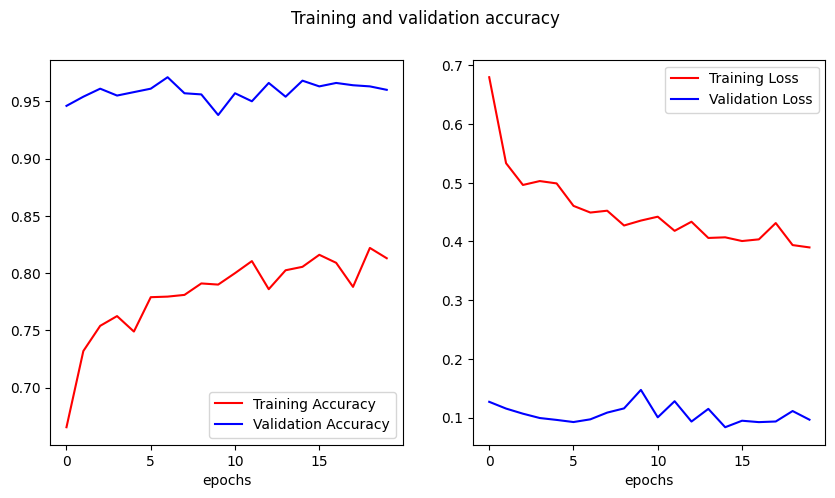

In [ ]:
import matplotlib.pyplot as plt

def plot_training_validation_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Training and validation accuracy')

    for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
        ax[i].plot(epochs, data[0], 'r', label="Training " + label)
        ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
        ax[i].legend()
        ax[i].set_xlabel('epochs')

    plt.show()

plot_training_validation_accuracy_loss(history)